# Quantum Support Vector Machine

1. [Qunatum Kernel](#Quantum-Kernel) \
    1.1 [Custom Implementation with Qiskit Circuit](#Custom-Implementation-with-Qiskit-Circuit) \
    1.2 [Qiskit Implementation](#Qiskit-Implementation) 
2. [Qunatum Support Vector Machine](#Quantum-Support-Vector-Machine)

In [177]:
from quantum_svm.quantum.feature_maps import ZZFeatureMap as ZZFeatureMap_custom
from quantum_svm.quantum.kernels import QuantumKernel
from quantum_svm.quantum.quantum_kernels import quantum_kernel
from quantum_svm.quantum.data_maps import DataMap, DataMap_Exp, DataMap_Sin, DataMap_Cos
from quantum_svm.svm.nonlinear_classifier import kernelSVC
from quantum_svm.utils.utils import compare_models, compare_model_performance
from quantum_svm.data.data_generators import (
    create_XOR_data, 
    create_moons_data, 
    create_circles_data, 
    adhoc_dataset
)
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from qiskit import Aer

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quantum Kernel 
### Validation of Custom Implementation

In [65]:
# Initialize Random Data
X = np.random.rand(80,2)

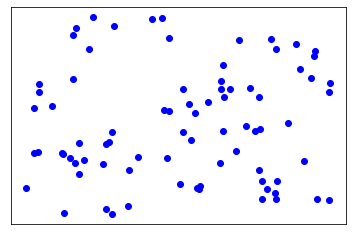

In [76]:
plt.scatter(X[:,0], X[:,1], c='b')
plt.xticks([])
plt.yticks([]);

### Custom Implementation with Qiskit Circuit

In [67]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

In [68]:
data_map = DataMap()

zz_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

zz_map_custom

ZZFeatureMap(feature_dimensions=2, reps=2)

In [69]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel(feature_map=zz_map_custom, quantum_backend=backend, sim_params=quantum_params)

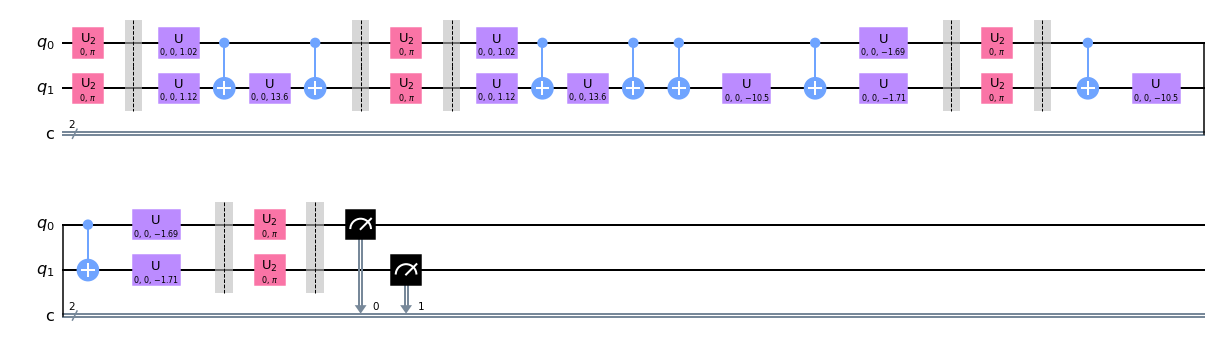

In [70]:
circuit = zz_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

In [71]:
QK_custom = zz_kernel.evaluate(X)

### Qiskit Implementation 

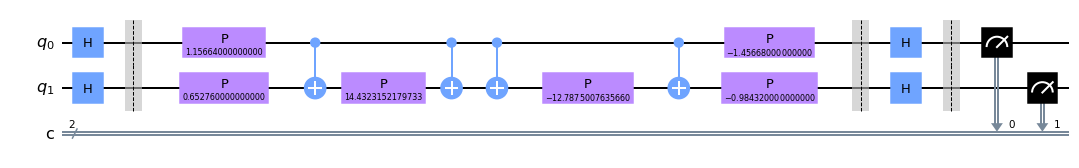

In [72]:
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap

zz_map = ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear', insert_barriers=True)

zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('qasm_simulator'))

zz_circuit = zz_kernel.construct_circuit(np.array([0.57832, 0.32638]), np.array([0.72834, 0.49216]))
zz_circuit.decompose().decompose().draw(output='mpl')

In [73]:
QK = quantum_kernel(quantum_params)

In [74]:
QK_X = QK(X)

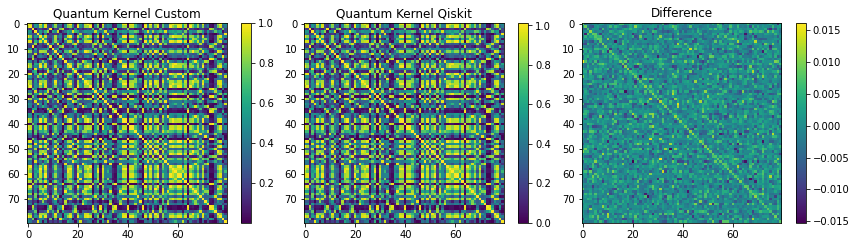

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
im = ax[0].imshow(np.asmatrix(QK_custom),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax[0].set_title("Quantum Kernel Custom")
im = ax[1].imshow(np.asmatrix(QK_X),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[1].set_title("Quantum Kernel Qiskit")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[2].imshow(QK_X - QK_custom, interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[2].set_title("Difference")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()

## Quantum Support Vector Machine

In [80]:
alpha_tol = 1e-04
colors = ['red', 'blue']
cmap_custom = pltcolors.ListedColormap(colors)
cmap = plt.cm.RdBu_r


seed = 12

### Datasets

In [171]:
# Params

center = 1
params_xor = {
    'N': 10, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 10, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 10, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 10,
    'test_size': 5,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [172]:
datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

### Classifiers

In [173]:
data_maps = [
    DataMap(), 
    DataMap_Exp(), 
    DataMap_Sin(), 
    DataMap_Cos()
]

In [182]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}


classifiers = []

for data_map in data_maps:
    classifiers.append( kernelSVC(
                            kernel='quantum', 
                            quantum_parans=quantum_params,
                            data_map=data_map,
                            qiskit=False,
                            verbose=True
                        ),
                      )

SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0] if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, exp{(|x[i] - x[j]|^2/(8/ln(pi)))} if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, sin((pi - x[i]))sin((pi - x[j])) if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, pi/3*(1/(cos(x[i])cos(x[j]))) if S={i,j})'')


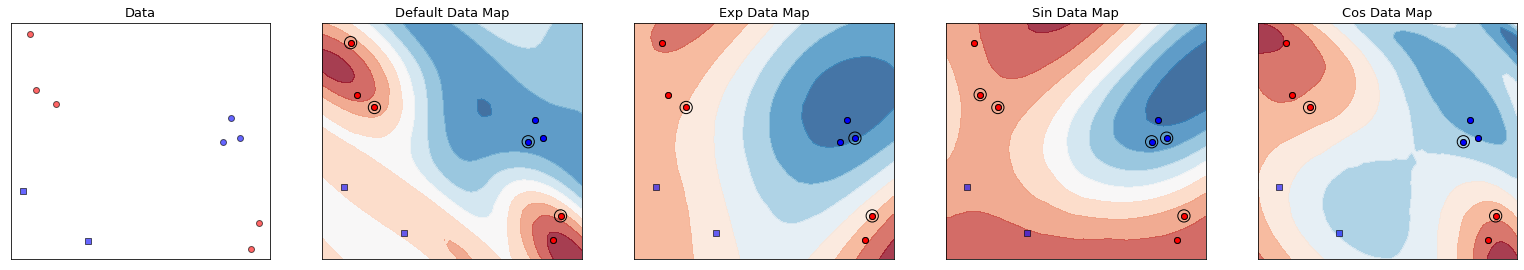

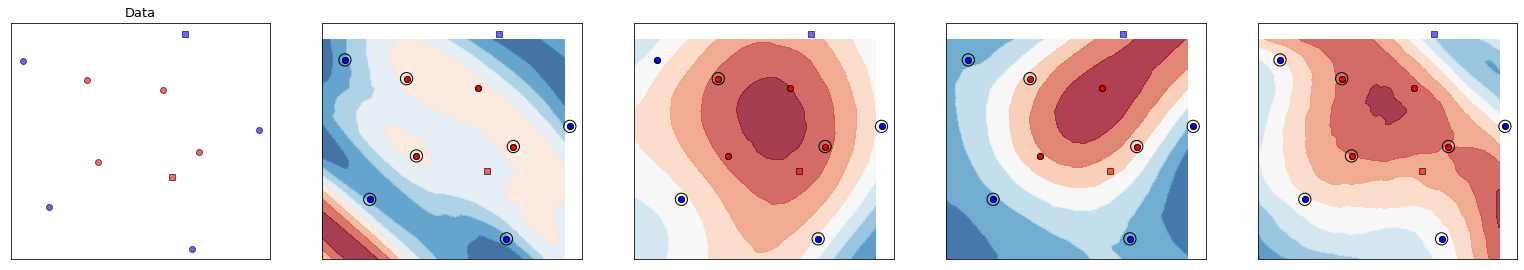

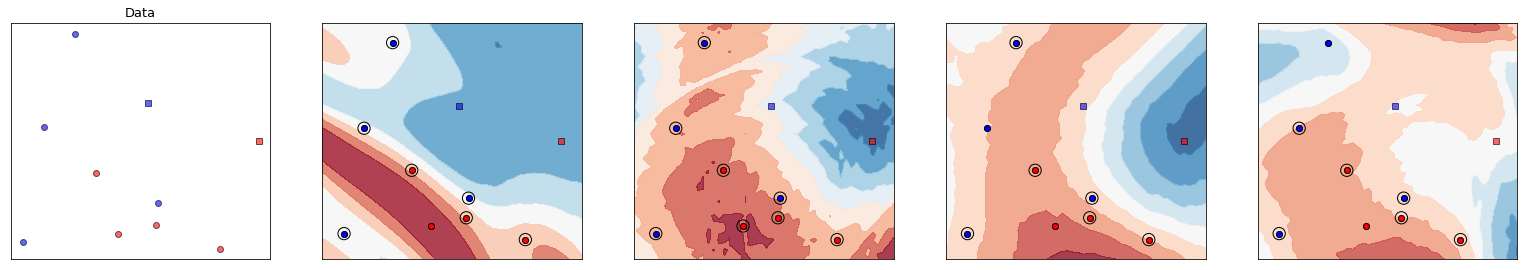

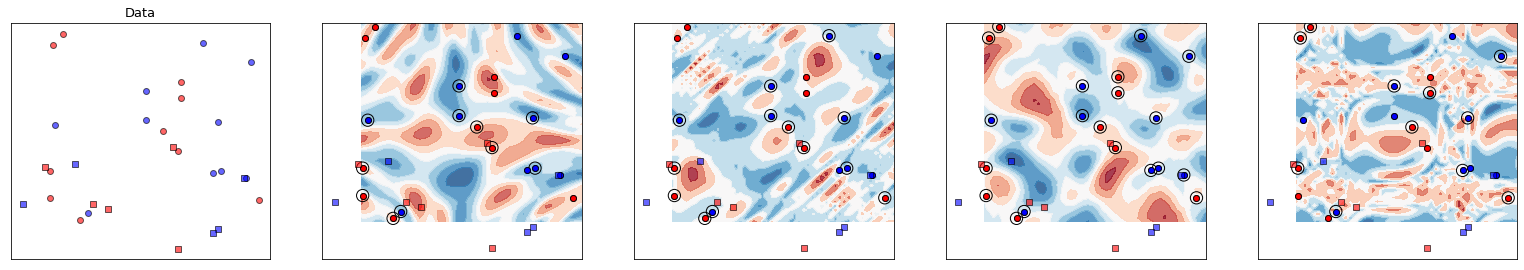

Time to compute: 535.7875156323115 min


In [175]:
compare_models(
    datasets, 
    classifiers, 
    ['Default Data Map',
     'Exp Data Map', 
     'Sin Data Map', 
     'Cos Data Map'],
)

In [178]:
# Params

center = 1
params_xor = {
    'N': 80, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 80, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 80, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 2,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

In [184]:
model_performance_on_datamaps = compare_model_performance(
                                        datasets, 
                                        classifiers, 
                                        ['XOR Data', 'Cirles Data', 'Moons Data', 'Adhoc Data'],
                                        ['Default Data Map', 'Exp Data Map', 'Sin Data Map', 'Cos Data Map']
                                )


compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 9 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [01:02<00:00,  1.02batch/s]


Accuracy on training set: 100.0 %


100%|████████████████████████████████████████| 16/16 [00:14<00:00,  1.13batch/s]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 61 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:40<00:00,  6.26s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:38<00:00,  6.18s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:53<00:00,  6.46s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.67s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 9 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [01:00<00:00,  1.05batch/s]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [00:15<00:00,  1.07batch/s]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/batch]


Accuracy on training set: 98.4375 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.66s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 60 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:33<00:00,  6.15s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:35<00:00,  5.97s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:59<00:00,  6.56s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:54<00:00,  7.15s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.06s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:49<00:00,  6.85s/batch]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 62 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/batch]


Accuracy on training set: 85.9375 %


100%|████████████████████████████████████████| 16/16 [01:43<00:00,  6.48s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:59<00:00,  7.48s/batch]


Accuracy on training set: 89.0625 %


100%|████████████████████████████████████████| 16/16 [01:49<00:00,  6.86s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 63 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:39<00:00,  6.24s/batch]


Accuracy on training set: 87.5 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.65s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:02<00:00,  6.61s/batch]


Accuracy on training set: 92.1875 %


100%|████████████████████████████████████████| 16/16 [01:45<00:00,  6.59s/batch]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:45<00:00,  1.32s/batch]


Accuracy on training set: 100.0 %


100%|██████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 79 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [11:13<00:00,  8.42s/batch]


Accuracy on training set: 86.25 %


100%|██████████████████████████████████████████| 4/4 [00:31<00:00,  7.81s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [11:53<00:00,  8.91s/batch]


Accuracy on training set: 81.25 %


100%|██████████████████████████████████████████| 4/4 [00:32<00:00,  8.05s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [10:43<00:00,  8.04s/batch]


Accuracy on training set: 70.0 %


100%|██████████████████████████████████████████| 4/4 [00:31<00:00,  7.84s/batch]


Cos Data Map computed!
Performance on Adhoc Data computed


Time to compute: 196.1936976313591 min


In [185]:
model_performance_on_datamaps


{'XOR Data': {'Default Data Map': 0.9375,
  'Exp Data Map': 1.0,
  'Sin Data Map': 1.0,
  'Cos Data Map': 1.0},
 'Cirles Data': {'Default Data Map': 1.0,
  'Exp Data Map': 1.0,
  'Sin Data Map': 1.0,
  'Cos Data Map': 1.0},
 'Moons Data': {'Default Data Map': 0.6875,
  'Exp Data Map': 0.625,
  'Sin Data Map': 0.8125,
  'Cos Data Map': 0.8125},
 'Adhoc Data': {'Default Data Map': 1.0,
  'Exp Data Map': 0.5,
  'Sin Data Map': 0.75,
  'Cos Data Map': 0.75}}